# Data Exploration

This notebook is used purely for exploring the datasets that have been provided by Udacity and documenting their contents.

In [1]:
# import libraries
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
# initialize spark
spark = SparkSession\
    .builder\
    .appName("data-exploration")\
    .getOrCreate()

22/04/06 00:15:03 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.1.9 instead (on interface wlo1)
22/04/06 00:15:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/06 00:15:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# pd config
pd.set_option("max_columns", 50)

## Airport Codes File

* This data was published on DataHub.io.
* It can be downloaded from: https://datahub.io/core/airport-codes#data
* This is a file containing information on 55075 transportation ports (i.e., airports, seaports, heliports, and baloonports) around the world.
* Closed transportation ports haven't been assigned a type, instead they've been marked as "closed" in the `type` column.
* We have codified data such as ISO code of the country the port belongs to, the ISO code of the region it belongs to, the GPS code, the IATA (the International Air Transport Association) code, and the local code (assuming this is the identification code used in the country it belongs to).
* We've also got the type of port, the name of theport, its elevation above sea level, the continent it belongs to (e.g. Europe, Asia, etc.,), the municipality within the country it belongs to, and its coordinates (or lattitude and longitude).

In [4]:
# read in file
ac = pd.read_csv("../data/airport-codes_csv.csv")

In [5]:
# head
ac.head(10)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"
5,00AS,small_airport,Fulton Airport,1100.0,NaN,US,US-OK,Alex,00AS,NaN,00AS,"-97.8180194, 34.9428028"
6,00AZ,small_airport,Cordes Airport,3810.0,NaN,US,US-AZ,Cordes,00AZ,NaN,00AZ,"-112.16500091552734, 34.305599212646484"
7,00CA,small_airport,Goldstone /Gts/ Airport,3038.0,NaN,US,US-CA,Barstow,00CA,NaN,00CA,"-116.888000488, 35.350498199499995"
8,00CL,small_airport,Williams Ag Airport,87.0,NaN,US,US-CA,Biggs,00CL,NaN,00CL,"-121.763427, 39.427188"
9,00CN,heliport,Kitchen Creek Helibase Heliport,3350.0,NaN,US,US-CA,Pine Valley,00CN,NaN,00CN,"-116.4597417, 32.7273736"


In [6]:
# info
ac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55075 entries, 0 to 55074
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ident         55075 non-null  object 
 1   type          55075 non-null  object 
 2   name          55075 non-null  object 
 3   elevation_ft  48069 non-null  float64
 4   continent     27356 non-null  object 
 5   iso_country   54828 non-null  object 
 6   iso_region    55075 non-null  object 
 7   municipality  49399 non-null  object 
 8   gps_code      41030 non-null  object 
 9   iata_code     9189 non-null   object 
 10  local_code    28686 non-null  object 
 11  coordinates   55075 non-null  object 
dtypes: float64(1), object(11)
memory usage: 5.0+ MB


In [7]:
# num of unique values in each field
for col in ac.columns:
    print(f"{col} unique values: {len(ac[col].unique())}")

ident unique values: 55075
type unique values: 7
name unique values: 52144
elevation_ft unique values: 5450
continent unique values: 7
iso_country unique values: 244
iso_region unique values: 2810
municipality unique values: 27134
gps_code unique values: 40851
iata_code unique values: 9043
local_code unique values: 27437
coordinates unique values: 54874


In [8]:
# type value counts
ac["type"].value_counts(dropna=False)

small_airport     33965
heliport          11287
medium_airport     4550
closed             3606
seaplane_base      1016
large_airport       627
balloonport          24
Name: type, dtype: int64

In [9]:
# continent value counts
ac["continent"].value_counts(dropna=False)

NaN    27719
EU      7840
SA      7709
AS      5350
AF      3362
OC      3067
AN        28
Name: continent, dtype: int64

In [10]:
# which types have iata codes
ac[ac["iata_code"].notnull()]["type"].unique()

array(['small_airport', 'seaplane_base', 'heliport', 'closed',
       'medium_airport', 'large_airport'], dtype=object)

In [11]:
# which types have the most iata codes
ac.pivot_table(
    index="type",
    values=["iata_code", "ident"],
    aggfunc="count"
).reset_index()\
    .rename(columns={"iata_code": "with_iata", "ident": "total"})\
    .sort_values("total", ascending=False)

,type,with_iata,total
6,small_airport,4238,33965
2,heliport,68,11287
4,medium_airport,3859,4550
1,closed,279,3606
5,seaplane_base,143,1016
3,large_airport,602,627
0,balloonport,0,24


## US Cities Demographics

* This data is provided by OpenDataSoft.
* It can be downloaded from: https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/
* This file contains demographic information for 2891 cities in the United States.
* The file mainly contains numerical information such as median age, gender-based population figures, average house-hold size, number of veterans, and number of foreign-born residents.
* While race and the population of each race for each city has been included in the data, the rest of the data for each city has not been segmented by race and is therefore duplicated across several records.

In [12]:
# read in the data
uscd = pd.read_csv("../data/us-cities-demographics.csv", sep=";")

In [13]:
# head
uscd.head(10)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402
5,Peoria,Illinois,33.1,56229.0,62432.0,118661,6634.0,7517.0,2.40,IL,American Indian and Alaska Native,1343
6,Avondale,Arizona,29.1,38712.0,41971.0,80683,4815.0,8355.0,3.18,AZ,Black or African-American,11592
7,West Covina,California,39.8,51629.0,56860.0,108489,3800.0,37038.0,3.56,CA,Asian,32716
8,O'Fallon,Missouri,36.0,41762.0,43270.0,85032,5783.0,3269.0,2.77,MO,Hispanic or Latino,2583
9,High Point,North Carolina,35.5,51751.0,58077.0,109828,5204.0,16315.0,2.65,NC,Asian,11060


In [14]:
# info
uscd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   City                    2891 non-null   object 
 1   State                   2891 non-null   object 
 2   Median Age              2891 non-null   float64
 3   Male Population         2888 non-null   float64
 4   Female Population       2888 non-null   float64
 5   Total Population        2891 non-null   int64  
 6   Number of Veterans      2878 non-null   float64
 7   Foreign-born            2878 non-null   float64
 8   Average Household Size  2875 non-null   float64
 9   State Code              2891 non-null   object 
 10  Race                    2891 non-null   object 
 11  Count                   2891 non-null   int64  
dtypes: float64(6), int64(2), object(4)
memory usage: 271.2+ KB


In [15]:
# is the data segmented by race?
uscd[uscd["City"].isin(["Silver Spring", "Quincy", "Avondale"])].sort_values(["City", "Race"])

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
1191,Avondale,Arizona,29.1,38712.0,41971.0,80683,4815.0,8355.0,3.18,AZ,American Indian and Alaska Native,613
142,Avondale,Arizona,29.1,38712.0,41971.0,80683,4815.0,8355.0,3.18,AZ,Asian,2828
6,Avondale,Arizona,29.1,38712.0,41971.0,80683,4815.0,8355.0,3.18,AZ,Black or African-American,11592
270,Avondale,Arizona,29.1,38712.0,41971.0,80683,4815.0,8355.0,3.18,AZ,Hispanic or Latino,34716
1778,Avondale,Arizona,29.1,38712.0,41971.0,80683,4815.0,8355.0,3.18,AZ,White,62176
426,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,American Indian and Alaska Native,351
2578,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,Asian,30473
2322,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,Black or African-American,3917
289,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,Hispanic or Latino,2566
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723


## I94 Immigration Data

* The data was collated by the US National Tourism and Trade Office.
* It cannot be downloaded and must be requested for: https://www.trade.gov/national-travel-and-tourism-office
* According to the I94_SAS_Labels_Descriptions.txt file:
    * `i94yr` is the 4 digit year
    * `i94mon` is the numeric month
    * `i94cit` is a 3-digit country code (can be converted to full names using the reference data provided) of the traveller's country of citizenship (assumption). Some codes correspond to invalid country names, country names that should not be shown, and some codes have not been assigned country names.
    * `i94res` is a 3-digit country code (can be converted to full names using the reference data provided) of the traveller's resident country (assumption). Some codes correspond to invalid country names, country names that should not be shown, or no country names.
    * `i94port` is a 3-digit code (can be converted to full names using the reference data provided) of the traveller's destination port (assumption). Some codes have not been assigned port names and some codes have been assigned to `Collapsed` values.
    * `arrdate` is the arrival date in the USA. These are stored as SAS numeric dates which are the number of days before (negative) or after (positive) January 1, 1960.
    * `i94mode` is a code that refers to the mode of travel. These can be converted to full labels using the reference data provided.
    * `i94addr` is the traveller's destination state (assumption). These can be converted to full labels using the reference data provided.
    * `depdate` is the departure date from the USA. These are stored as SAS numeric dates which are the number of days before (negative) or after (positive) January 1, 1960.
    * `i94bir` is the age of the traveller.
    * `i94visa` is a code that refers to the type of visa used for travel - business, leisure, or student. These can be converted to full labels using the reference data provided.
    * `count` is just full of 1s and is used for summary statistics.
    * `dtadfile` is a date field that seems to be in the format yyyymmdd.
    * `visapost` is the department of state where the visa was issued. There's no reference data to convert this into a full label.
    * `occup` is the occupation that'll be performed in the US. There's no reference data to convert this into a full label.
    * `entdepa`, `entdepd`, and `entdepu` refer to the status of arrival, departure, and updates. There's no reference data to convert this into a full label.
    * `matflag` is apparently the match of arrival and departure records. I'm assuming this refers to whether the documents presented on arrival and departure matched.
    * `biryear` is the traveller's birth year. A normal 4-digit year.
    * `dtaddto` is the date the traveller was allowed to stay in the US until. It seems to be in the format yyyymmdd.
    * `gender` is the gender of the traveller. There's no reference data to convert this into a full label.
    * `insnum` is the INS number although I'm not sure what this is.
    * `airline` is the airline that the traveller used to arrive. It's an abbreviation of the airline's name and there's no reference data for conversion into a full label.
    * `admnum` stands for admission number.
    * `fltno` is the flight number of the airline used to arrive to the US.
    * `visatype` is the type of visa used to enter the US. Compared to `i94visa` this refers to the exact visa code. There's no reference data for conversion.
* To expand on some of the codified values, I'm going to need to put together reference tables using the SAS Labels Descriptions file. For the other codified values without reference data in that file, I'm going to need to do some research to expand them if they're needed in my analytics use cases.

In [16]:
# read in the files -- both the csv and the parquet files
imm_csv = pd.read_csv("../data/immigration_data_sample.csv")
imm_pq = spark.read.parquet("../data/sas_data/")

In [17]:
# do both the csv and parquet files have the same columns?
imm_pq_cols = imm_pq.columns
imm_csv_cols = list(imm_csv.columns)[1:] # ignore index column

if len(imm_pq_cols) == len(imm_csv_cols):
    print("Both column lists are of the same size")
else:
    print("Both column lists aren't of the same size")

for col in imm_pq_cols:
    if col not in imm_csv_cols:
        print(f"{col} not in imm_csv")

for col in imm_csv_cols:
    if col not in imm_pq_cols:
        print(f"{col} not in imm_pq")

Both column lists are of the same size


In [18]:
# print schema
imm_pq.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [43]:
ac[ac["municipality"] == "Point Lay"]

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
39071,PPIZ,medium_airport,Point Lay LRRS Airport,22.0,NaN,US,US-AK,Point Lay,PPIZ,PIZ,PIZ,"-163.0050049, 69.73290253"


In [19]:
# head
imm_pq.limit(10).toPandas()

22/04/06 00:15:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,40.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1976.0,10292016,F,None,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,32.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1984.0,10292016,F,None,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,29.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1987.0,10292016,M,None,DL,9.495641e+10,00040,B1
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,29.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1987.0,10292016,F,None,DL,9.495645e+10,00040,B1
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,28.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1988.0,10292016,M,None,DL,9.495639e+10,00040,B1
5,5748522.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20579.0,57.0,2.0,1.0,20160430,ACK,None,G,O,None,M,1959.0,10292016,M,None,NZ,9.498180e+10,00010,B2
6,5748523.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20586.0,66.0,2.0,1.0,20160430,ACK,None,G,O,None,M,1950.0,10292016,F,None,NZ,9.497969e+10,00010,B2
7,5748524.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20586.0,41.0,2.0,1.0,20160430,ACK,None,G,O,None,M,1975.0,10292016,F,None,NZ,9.497975e+10,00010,B2
8,5748525.0,2016.0,4.0,245.0,464.0,HOU,20574.0,1.0,FL,20581.0,27.0,2.0,1.0,20160430,ACK,None,G,O,None,M,1989.0,10292016,M,None,NZ,9.497325e+10,00028,B2
9,5748526.0,2016.0,4.0,245.0,464.0,LOS,20574.0,1.0,CA,20581.0,26.0,2.0,1.0,20160430,ACK,None,G,O,None,M,1990.0,10292016,F,None,NZ,9.501355e+10,00002,B2


In [20]:
# number of nulls in each column
total_num_of_records = imm_pq.count()
print(f"The total number of records in imm_pq is: {total_num_of_records}")

for col in imm_pq.columns:
    num_of_missing_values = imm_pq.where(imm_pq[col].isNull()).count()
    perc_of_missing_values = round((num_of_missing_values / total_num_of_records) * 100, 2)
    print(f"{col} has {num_of_missing_values} nulls which is {perc_of_missing_values} of all records")

The total number of records in imm_pq is: 3096313
cicid has 0 nulls which is 0.0 of all records
i94yr has 0 nulls which is 0.0 of all records
i94mon has 0 nulls which is 0.0 of all records
i94cit has 0 nulls which is 0.0 of all records
i94res has 0 nulls which is 0.0 of all records
i94port has 0 nulls which is 0.0 of all records
arrdate has 0 nulls which is 0.0 of all records
i94mode has 239 nulls which is 0.01 of all records
i94addr has 152592 nulls which is 4.93 of all records
depdate has 142457 nulls which is 4.6 of all records
i94bir has 802 nulls which is 0.03 of all records
i94visa has 0 nulls which is 0.0 of all records
count has 0 nulls which is 0.0 of all records
dtadfile has 1 nulls which is 0.0 of all records
visapost has 1881250 nulls which is 60.76 of all records
occup has 3088187 nulls which is 99.74 of all records
entdepa has 238 nulls which is 0.01 of all records
entdepd has 138429 nulls which is 4.47 of all records
entdepu has 3095921 nulls which is 99.99 of all record

In [21]:
# what unique values does the count column contain
imm_pq.select("count").dropDuplicates().show()

+-----+
|count|
+-----+
|  1.0|
+-----+



In [22]:
# how many unique values are in the dtadfile
imm_pq.select("dtadfile").count()

3096313

In [23]:
def unique_count_and_sample(df, field, sample_count=5):
    """
    Print the number of unique values in a column
    and export a sample of them in a list
    """
    deduped = df.select(field).dropDuplicates()
    print(f"Number of values in {field}: {deduped.count()}")
    print(f"Sample of values in {field}: {[x[0] for x in deduped.collect()[:sample_count]]}")

In [24]:
# occup column - uniques and sample
unique_count_and_sample(imm_pq, "occup")

# visapost column - uniques and sample
unique_count_and_sample(imm_pq, "visapost")

Number of values in occup: 112
Sample of values in occup: ['ACH', '101', 'ULS', 'GEN', 'MTH']
Number of values in visapost: 531
Sample of values in visapost: ['CRS', 'KGL', 'AKD', 'KAT', 'TRK']


In [25]:
# entdepa column - uniques and sample
unique_count_and_sample(imm_pq, "entdepa", 14)

# entdepd column - uniques and sample
unique_count_and_sample(imm_pq, "entdepd", 14)

# entdepu column - uniques and sample
unique_count_and_sample(imm_pq, "entdepu", 3)

# matflag column - uniques and sample
unique_count_and_sample(imm_pq, "matflag", 2)

Number of values in entdepa: 14
Sample of values in entdepa: ['K', None, 'T', 'B', 'M', 'U', 'O', 'Z', 'A', 'N', 'G', 'P', 'H', 'F']
Number of values in entdepd: 13
Sample of values in entdepd: ['K', 'Q', None, 'L', 'M', 'V', 'O', 'D', 'J', 'N', 'W', 'R', 'I']
Number of values in entdepu: 3
Sample of values in entdepu: [None, 'U', 'Y']
Number of values in matflag: 2
Sample of values in matflag: [None, 'M']


In [26]:
# gender column - uniques and samples
unique_count_and_sample(imm_pq, "gender")

# airline column - unique and samples
unique_count_and_sample(imm_pq, "airline")

# visatype column - unique and samples
unique_count_and_sample(imm_pq, "visatype", 17)

Number of values in gender: 5
Sample of values in gender: ['F', None, 'M', 'U', 'X']
Number of values in airline: 535
Sample of values in airline: ['MM', 'DZ', 'CI', 'TC', 'AZ']
Number of values in visatype: 17
Sample of values in visatype: ['F2', 'GMB', 'B2', 'F1', 'CPL', 'I1', 'WB', 'M1', 'B1', 'WT', 'M2', 'CP', 'GMT', 'E1', 'I', 'E2', 'SBP']


In [27]:
# i94addr column - uniques and samples
unique_count_and_sample(imm_pq, "i94addr")

Number of values in i94addr: 458
Sample of values in i94addr: ['CI', 'SC', 'AZ', 'PU', 'UA']


In [28]:
# time period of the sample dataset
print("Max month:", imm_pq.agg({"i94mon": "max"}).collect()[0][0])
print("Min month:", imm_pq.agg({"i94mon": "min"}).collect()[0][0])
print("Max year:", imm_pq.agg({"i94yr": "max"}).collect()[0][0])
print("Min year:", imm_pq.agg({"i94yr": "min"}).collect()[0][0])

Max month: 4.0
Min month: 4.0
Max year: 2016.0
Min year: 2016.0


## Global Land Temperatures by City

* The data was collated by the non-profit Berkely Earth.
* Source: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCity.csv
* This is a large file that contains time series data of the average temperature observed of 3448 cities across 159 countries.
* There are only 5 columns - the date in yyyy-mm-dd format, the average temperature, the uncertainty percentage (95% confidence interval), the city, the country, and the coordinates of the city.

In [29]:
# read everything in
temp = spark.read.csv("../data/GlobalLandTemperaturesByCity.csv", header=True)

In [30]:
# print schema
temp.printSchema()

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: string (nullable = true)
 |-- AverageTemperatureUncertainty: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [31]:
# head
temp.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.7369999999999999,Århus,Denmark,57.05N,10.33E
1,1743-12-01,None,None,Århus,Denmark,57.05N,10.33E
2,1744-01-01,None,None,Århus,Denmark,57.05N,10.33E
3,1744-02-01,None,None,Århus,Denmark,57.05N,10.33E
4,1744-03-01,None,None,Århus,Denmark,57.05N,10.33E


In [32]:
# span of the dataset
temp = temp.withColumn("dt", F.to_date(temp["dt"]))
print("Max date:", temp.agg({"dt": "max"}).collect()[0])
print("Min date:", temp.agg({"dt": "min"}).collect()[0])

Max date: Row(max(dt)=datetime.date(2013, 9, 1))


Min date: Row(min(dt)=datetime.date(1743, 11, 1))


In [33]:
# number of cities in this sample
unique_count_and_sample(temp, "city")

# number of countries in this sample
unique_count_and_sample(temp, "country")

Number of values in city: 3448


Sample of values in city: ['Antwerp', 'Araruama', 'Bangalore', 'Benxi', 'Abuja']


Number of values in country: 159


Sample of values in country: ['Russia', 'Paraguay', 'Yemen', 'Burma', 'Philippines']


In [34]:
# do the lat and long change by city
temp.select("Country", "City", "Latitude", "Longitude").dropDuplicates().sort([temp["Country"], temp["City"]]).show(n=20)

+-----------+-----------+--------+---------+
|    Country|       City|Latitude|Longitude|
+-----------+-----------+--------+---------+
|Afghanistan|     Baglan|  36.17N|   69.61E|
|Afghanistan|     Gardez|  32.95N|   69.89E|
|Afghanistan|      Gazni|  32.95N|   67.98E|
|Afghanistan|      Herat|  34.56N|   62.27E|
|Afghanistan|  Jalalabad|  34.56N|   70.05E|
|Afghanistan|      Kabul|  34.56N|   70.05E|
|Afghanistan|   Qandahar|  31.35N|   65.97E|
|Afghanistan|     Qunduz|  36.17N|   69.61E|
|    Albania|     Durrës|  40.99N|   19.17E|
|    Albania|    Elbasan|  40.99N|   19.17E|
|    Albania|     Tirana|  40.99N|   19.17E|
|    Algeria|    Algiers|  36.17N|    3.98E|
|    Algeria|Constantine|  36.17N|    5.97E|
|    Algeria|      Médéa|  36.17N|    1.99E|
|    Algeria|     Wahran|  36.17N|    0.00W|
|    Algeria|     Warqla|  31.35N|    5.65E|
|     Angola|   Benguela|  12.05S|   13.15E|
|     Angola|     Huambo|  13.66S|   15.69E|
|     Angola|      Kuito|  12.05S|   16.44E|
|     Ango

<AxesSubplot:xlabel='dt'>

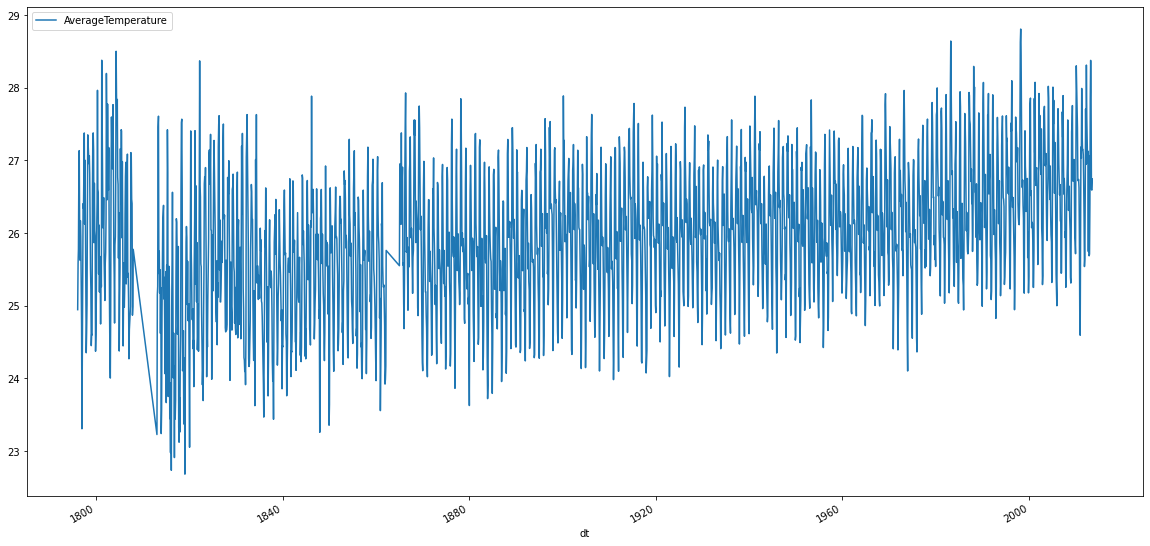

In [35]:
# out of curiosity, get the records for colombo, sri lanka and visualize them
# remove null values
sl_temp = temp.where(
    (temp["City"] == "Colombo") & 
    (temp["Country"] == "Sri Lanka") &
    (temp["AverageTemperature"].isNotNull())
).toPandas()

sl_temp["dt"] = pd.to_datetime(sl_temp["dt"]) # convert to datetime
sl_temp["AverageTemperature"] = sl_temp["AverageTemperature"].astype(float) # convert avg temp to float

# visual
sl_temp.plot(
    x="dt",
    y="AverageTemperature",
    kind="line",
    figsize=(20,10)
)

---

## Cross-File Observations

* Despite the favourable numbers below, upon conducting spot checks of the `iata_code` in the Airport Codes file and the `i94port` label in the SAS Labels file, I discovered that many of them don't match up. So we can't use the `iata_code` and the `i94port` code to merge the two files together accurately. We'll need to use the city label corresponding to the `i94port` code.
* The majority of cities in the US Demographics Dataset and the Temperature Dataset can be found in the Airline Codes Dataset.
* The majority of cities in the Temperature Dataset can be found in the US Demographics Dataset.

In [36]:
# i94 data
imm_pq.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,40.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1976.0,10292016,F,None,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,32.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1984.0,10292016,F,None,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,29.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1987.0,10292016,M,None,DL,9.495641e+10,00040,B1
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,29.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1987.0,10292016,F,None,DL,9.495645e+10,00040,B1
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,28.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1988.0,10292016,M,None,DL,9.495639e+10,00040,B1


In [37]:
# airport codes
ac.head(5)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [38]:
# us cities
uscd.head(5)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [39]:
# global land temps
temp.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.7369999999999999,Århus,Denmark,57.05N,10.33E
1,1743-12-01,None,None,Århus,Denmark,57.05N,10.33E
2,1744-01-01,None,None,Århus,Denmark,57.05N,10.33E
3,1744-02-01,None,None,Århus,Denmark,57.05N,10.33E
4,1744-03-01,None,None,Århus,Denmark,57.05N,10.33E


#### Can we use the `i94port` value with either `local_code` or `iata_code`?

In [40]:
# get a list of all the unique i94port values
i94port_unique = imm_pq.select("i94port").dropDuplicates().toPandas()

# check if the i94port is in either the local_code or iata_code columns
i94port_unique["in_local_code"] = i94port_unique["i94port"].apply(lambda x: 1 if x in ac[ac["iso_country"] == "US"]["local_code"].unique() else 0)
i94port_unique["in_iata_code"] = i94port_unique["i94port"].apply(lambda x: 1 if x in ac[ac["iso_country"] == "US"]["iata_code"].unique() else 0)

# statistics
print(f"Total number of sample ports: {len(i94port_unique)}")
print(f"Number of sample ports in local_code: {i94port_unique['in_local_code'].sum()}")
print(f"Number of sample ports in iata_code: {i94port_unique['in_iata_code'].sum()}")

Total number of sample ports: 299
Number of sample ports in local_code: 145
Number of sample ports in iata_code: 132


In [68]:
# get a list of all the unique i94port values (airports only)
i94port_unique = imm_pq.where(imm_pq["i94mode"] == 1).select("i94port").dropDuplicates().toPandas()

# check if the i94port is in either the local_code or iata_code columns (for airports only)
i94port_unique["in_local_code"] = i94port_unique["i94port"].apply(
    lambda x: 1 if x in ac[
        (ac["iso_country"] == "US") & 
        (ac["type"].isin(["small_airport", "medium_airport", "large_airport"]))
        ]["local_code"].unique() else 0
    )

i94port_unique["in_iata_code"] = i94port_unique["i94port"].apply(
    lambda x: 1 if x in ac[
        (ac["iso_country"] == "US") & 
        (ac["type"].isin(["small_airport", "medium_airport", "large_airport"]))
        ]["iata_code"].unique() else 0
    )

# statistics (airports only)
print(f"Total number of sample airports: {len(i94port_unique)}")
print(f"Number of sample airports in local_code: {i94port_unique['in_local_code'].sum()}")
print(f"Number of sample airports in iata_code: {i94port_unique['in_iata_code'].sum()}")

Total number of sample airports: 181
Number of sample airports in local_code: 107
Number of sample airports in iata_code: 100


#### How many `municipality` values in the airport code dataset are in the demographics and temperature data?

In [98]:
# get list of municipalities in the us
ac_muni = ac[
    (ac["iso_country"] == "US") & 
    (ac["municipality"].notnull())
][["municipality"]].drop_duplicates()
ac_muni["municipality"] = ac_muni["municipality"].apply(lambda x: x.upper())

# get list of uscd cities
uscd_cities = uscd["City"].drop_duplicates().tolist()
uscd_cities = list(map(lambda x: x.upper(), uscd_cities))

# get list of temp cities
temp_cities = temp.where(temp["Country"] == "United States").select("City").dropDuplicates().toPandas()["City"].tolist()
temp_cities = list(map(lambda x: x.upper(), temp_cities))

# check how many municipalities are in uscd cities and temp cities
ac_muni["in_uscd"] = ac_muni["municipality"].apply(lambda x: 1 if x in uscd_cities else 0)
ac_muni["in_temp"] = ac_muni["municipality"].apply(lambda x: 1 if x in temp_cities else 0)

# check how many temp cities are in uscd cities
temp_uscd_common = len([x for x in temp_cities if x in uscd_cities])

# statistics
print(f"Total number of cities in Airport Codes Dataset: {len(ac_muni)}")
print(f"Total number of cities in US Demographics Dataset: {len(uscd_cities)}")
print(f"Total number of cities in Temperature Dataset: {len(temp_cities)}")
print(f"Total number of cities in Airport Codes and US Demographics: {ac_muni['in_uscd'].sum()}")
print(f"Total number in cities in Airport Codes and Temperature: {ac_muni['in_temp'].sum()}")
print(f"Total number in cities in US Demographics and Temperature: {temp_uscd_common}")

Total number of cities in Airport Codes Dataset: 8738
Total number of cities in US Demographics Dataset: 567
Total number of cities in Temperature Dataset: 248
Total number of cities in Airport Codes and US Demographics: 477
Total number in cities in Airport Codes and Temperature: 231
Total number in cities in US Demographics and Temperature: 239


---